# Projekt 1 - Odszumianie

In [1]:
import glob
import os
from pathlib import Path

from PIL import Image
import numpy as np
from skimage.util import random_noise
from skimage.restoration import denoise_bilateral
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error
from skimage.metrics import structural_similarity as ssim
from skimage import io
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision.utils import save_image
import cv2
import lpips

## Przygotowanie danych

In [2]:
def resize_img(img: Image) -> Image:
    width, height = img.size
    img_cropped = img.crop([0, 0, min(width, height), min(width, height)])
    img_resized = img_cropped.resize((256, 256))
    return img_resized

In [67]:
def add_noise(img: Image) -> Image:
    pixels = np.asarray(img)
    pixels_noisy = random_noise(pixels, mean=0.01, var=0.03)
    return Image.fromarray(np.uint8(pixels_noisy * 255))

In [74]:
for set_type in ("train", "valid"):
    os.mkdir(f"{set_type}_gt")
    os.mkdir(f"{set_type}_noisy")
    for path in glob.glob(f"DIV2K_{set_type}_HR/*.png"):
        img = Image.open(path)
        resized_img = resize_img(img)
        resized_img.save(f"{set_type}_gt/{Path(path).name}")
        noisy_img = add_noise(resized_img)
        noisy_img.save(f"{set_type}_noisy/{Path(path).name}")

## Odszumianie za pomocą DnCNN (https://ieeexplore.ieee.org/document/7839189)

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [3]:
class DenoisingDataset(Dataset):
    def __init__(self, root_dir_gt, root_dir_noisy, transform=None):
        self.root_dir_gt = root_dir_gt
        self.root_dir_noisy = root_dir_noisy
        self.transform = transform
        self.image_list_gt = sorted(glob.glob(f"{self.root_dir_gt}/*.png"))
        self.image_list_noisy = sorted(glob.glob(f"{self.root_dir_noisy}/*.png"))

    def __len__(self):
        return len(self.image_list_gt)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_gt = io.imread(self.image_list_gt[idx])
        image_noisy = io.imread(self.image_list_noisy[idx])
        
        if self.transform:
            image_gt = self.transform(image_gt)
            image_noisy = self.transform(image_noisy)

        return image_gt, image_noisy 

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = DenoisingDataset("train_gt", "train_noisy", transform=transform)
valid_dataset = DenoisingDataset("valid_gt", "valid_noisy", transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False, pin_memory=True)

In [ ]:
# Based on https://github.com/SaoYan/DnCNN-PyTorch/tree/master.
class DnCNN(nn.Module):
    def __init__(self, channels, num_of_layers=17):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        features = 64
        layers = []
        layers.append(nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_of_layers-2):
            layers.append(nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=features, out_channels=channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.dncnn(x)
        return out
    
net = DnCNN(3).to(device)

In [ ]:
summary(net, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,864
       BatchNorm2d-4         [-1, 64, 256, 256]             128
              ReLU-5         [-1, 64, 256, 256]               0
            Conv2d-6         [-1, 64, 256, 256]          36,864
       BatchNorm2d-7         [-1, 64, 256, 256]             128
              ReLU-8         [-1, 64, 256, 256]               0
            Conv2d-9         [-1, 64, 256, 256]          36,864
      BatchNorm2d-10         [-1, 64, 256, 256]             128
             ReLU-11         [-1, 64, 256, 256]               0
           Conv2d-12         [-1, 64, 256, 256]          36,864
      BatchNorm2d-13         [-1, 64, 256, 256]             128
             ReLU-14         [-1, 64, 2

In [ ]:
criterion = nn.MSELoss(size_average=False)
optimizer = optim.Adam(net.parameters(), lr=0.001)

/home/asia/anaconda3/envs/hf/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
train_loss = []
epochs = 30
for epoch in range(epochs):
    running_loss = 0.0
    for data in train_loader:
        gt, noisy = data
        gt, noisy = gt.to(device), noisy.to(device)
        optimizer.zero_grad()
        outputs = net(noisy)
        loss = criterion(outputs, gt) / (noisy.size()[0]*2)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss = running_loss / len(train_loader)
    train_loss.append(loss)
    print('Epoch {} of {}, Train Loss: {:.4f}'.format(epoch+1, epochs, loss))

Epoch 1 of 30, Train Loss: 3853.3431
Epoch 2 of 30, Train Loss: 1178.5194
Epoch 3 of 30, Train Loss: 1080.9711
Epoch 4 of 30, Train Loss: 1002.3769
Epoch 5 of 30, Train Loss: 920.9542
Epoch 6 of 30, Train Loss: 971.6762
Epoch 7 of 30, Train Loss: 879.3713
Epoch 8 of 30, Train Loss: 961.3493
Epoch 9 of 30, Train Loss: 995.8040
Epoch 10 of 30, Train Loss: 890.6460
Epoch 11 of 30, Train Loss: 867.0672
Epoch 12 of 30, Train Loss: 889.3771
Epoch 13 of 30, Train Loss: 909.8602
Epoch 14 of 30, Train Loss: 808.0761
Epoch 15 of 30, Train Loss: 717.3562
Epoch 16 of 30, Train Loss: 920.9465
Epoch 17 of 30, Train Loss: 726.8096
Epoch 18 of 30, Train Loss: 701.9512
Epoch 19 of 30, Train Loss: 673.3846
Epoch 20 of 30, Train Loss: 790.5703
Epoch 21 of 30, Train Loss: 714.1318
Epoch 22 of 30, Train Loss: 702.6141
Epoch 23 of 30, Train Loss: 719.8465
Epoch 24 of 30, Train Loss: 761.5645
Epoch 25 of 30, Train Loss: 740.8341
Epoch 26 of 30, Train Loss: 588.8034
Epoch 27 of 30, Train Loss: 563.6194
Epoch 

In [ ]:
with torch.no_grad():
    for i, batch in enumerate(valid_loader):
        gt, noisy = batch
        gt, noisy = gt.to(device), noisy.to(device)
        outputs = net(noisy).cpu()
        outputs = torch.clip(outputs, 0, 1)
        for j, out in enumerate(torch.split(outputs, 1)):
            out = out.squeeze(0).detach().cpu()
            save_image(out, f"valid_denoised/0{801+i*16+j}.png")

## Porównanie wyników z funkcją `denoise_bilateral` z skimage

### Przykładowe zdjęcia po odszumianiu dwiema metodami

In [139]:
def get_baseline(batch):
    baseline = []
    for tensor in torch.split(batch, 1):
        tensor = tensor.squeeze(0).detach().cpu()
        array = np.array(tensor.permute(1, 2, 0)*255, dtype=np.uint8)
        denoised = denoise_bilateral(array / 255, channel_axis=-1)
        baseline.append(torch.from_numpy(denoised).permute(2, 0, 1).unsqueeze(0))

    baseline = torch.cat(baseline)
    return baseline

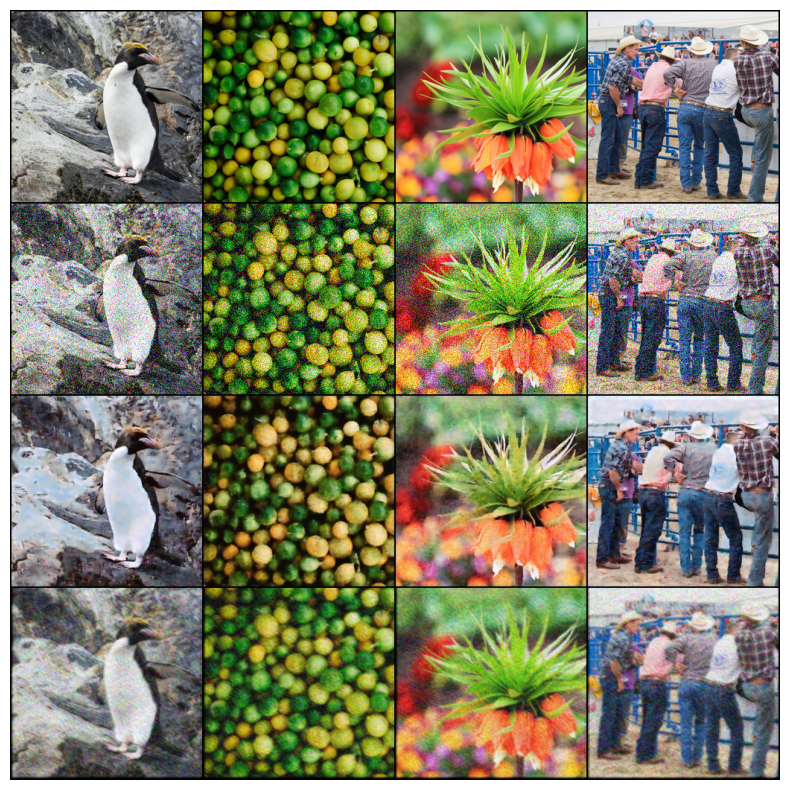

In [ ]:
with torch.no_grad():
    for batch in valid_loader:
        gt, noisy = batch
        gt, noisy = gt.to(device), noisy.to(device)
        outputs = net(noisy).cpu()
        outputs = torch.clip(outputs, 0, 1)

        baseline = get_baseline(noisy.cpu())
       
        grid = torchvision.utils.make_grid(
            torch.cat((gt[0:4].cpu(), noisy[0:4].cpu(), outputs[0:4], baseline[0:4])),
            nrow=4
        )
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(40,10))
        plt.axis('off')
        plt.imshow(grid)

        break

### Metryka Squared Norm Error

In [8]:
sne_dncnn = []
sne_baseline = []
for path in glob.glob(f"valid_gt/*.png"):
    img_gt = cv2.imread(path, cv2.COLOR_BGR2RGB)
    img_noisy =  cv2.imread(f"valid_noisy/{Path(path).name}", cv2.COLOR_BGR2RGB)
    img_dcnn = cv2.imread(f"valid_denoised/{Path(path).name}", cv2.COLOR_BGR2RGB)
    img_baseline = denoise_bilateral(img_noisy/255, channel_axis=-1)
    sne_dncnn.append(mean_squared_error(img_gt/255, img_dcnn/255) * (256*256))
    sne_baseline.append(mean_squared_error(img_gt/255, img_baseline) * (256*256))

print(f"SNE for bilateral denoising: {sum(sne_baseline)/len(sne_baseline):.3f}")
print(f"SNE for DnCNN: {sum(sne_dncnn)/len(sne_dncnn):.3f}")

SNE for bilateral denoising: 940.346
SNE for DnCNN: 402.830


### Metryka Peak Signal Noise Ratio

In [173]:
psnr_dncnn = []
psnr_baseline = []
for path in glob.glob(f"valid_gt/*.png"):
    img_gt = cv2.imread(path, cv2.COLOR_BGR2RGB)
    img_noisy =  cv2.imread(f"valid_noisy/{Path(path).name}", cv2.COLOR_BGR2RGB)
    img_dcnn = cv2.imread(f"valid_denoised/{Path(path).name}", cv2.COLOR_BGR2RGB)
    img_baseline = denoise_bilateral(img_noisy / 255, channel_axis=-1)
    psnr_dncnn.append(peak_signal_noise_ratio(img_gt, img_dcnn))
    psnr_baseline.append(peak_signal_noise_ratio(img_gt, np.uint8(img_baseline * 255)))

print(f"PSNR for bilateral denoising: {sum(psnr_baseline)/len(psnr_baseline):.3f}")
print(f"PSNR for DnCNN: {sum(psnr_dncnn)/len(psnr_dncnn):.3f}")

PSNR for bilateral denoising: 18.884
PSNR for DnCNN: 22.536


### Metryka Structural Similarity Index

In [180]:
ssim_dncnn = []
ssim_baseline = []
for path in glob.glob(f"valid_gt/*.png"):
    img_gt = cv2.imread(path, cv2.COLOR_BGR2RGB)
    img_noisy =  cv2.imread(f"valid_noisy/{Path(path).name}", cv2.COLOR_BGR2RGB)
    img_dcnn = cv2.imread(f"valid_denoised/{Path(path).name}", cv2.COLOR_BGR2RGB)
    img_baseline = denoise_bilateral(img_noisy / 255, channel_axis=-1)
    ssim_dncnn.append(ssim(img_gt, img_dcnn, channel_axis=-1))
    ssim_baseline.append(ssim(img_gt, np.uint8(img_baseline * 255), channel_axis=-1))

print(f"SSIM for bilateral denoising: {sum(ssim_baseline)/len(ssim_baseline):.3f}")
print(f"SSIM for DnCNN: {sum(ssim_dncnn)/len(ssim_dncnn):.3f}")

SSIM for bilateral denoising: 0.337
SSIM for DnCNN: 0.735


### Metryka Learned Perceptual Image Patch Similarity

In [ ]:
lpips_dncnn = []
lpips_baseline = []
loss_fn_alex = lpips.LPIPS(net='alex')
for path in glob.glob(f"valid_gt/*.png"):
    img_gt = cv2.imread(path, cv2.COLOR_BGR2RGB)
    img_noisy =  cv2.imread(f"valid_noisy/{Path(path).name}", cv2.COLOR_BGR2RGB)
    img_dcnn = cv2.imread(f"valid_denoised/{Path(path).name}", cv2.COLOR_BGR2RGB)
    img_baseline = denoise_bilateral(img_noisy / 255, channel_axis=-1)
    img_gt_tensor = lpips.im2tensor(img_gt)
    img_dcnn_tensor = lpips.im2tensor(img_dcnn)
    img_baseline_tensor = lpips.im2tensor(np.uint8(img_baseline * 255))
    lpips_dncnn.append(loss_fn_alex(img_gt_tensor, img_dcnn_tensor))
    lpips_baseline.append(loss_fn_alex(img_gt_tensor, img_baseline_tensor))

print(f"LPIPS for bilateral denoising: {(sum(lpips_baseline)/len(lpips_baseline)).detach().item():.3f}")
print(f"LPIPS for DnCNN: {(sum(lpips_dncnn)/len(lpips_dncnn)).detach().item():.3f}")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/asia/anaconda3/envs/hf/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asia/anaconda3/envs/hf/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/asia/anaconda3/envs/hf/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


/home/asia/anaconda3/envs/hf/lib/python3.12/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_l

LPIPS for bilateral denoising: 0.479
LPIPS for DnCNN: 0.246
